In [1]:
import torch
import argparse
import csv   
import datetime

import math
import torch.nn as nn 
from torch.nn.functional import leaky_relu, softmax
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from collections import Counter

from GANutils import *
from utils import *
from validationUtils import *
from plotUtils import *
from TUutils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

#### Visualise the Training for WGAN or WGAN-GP

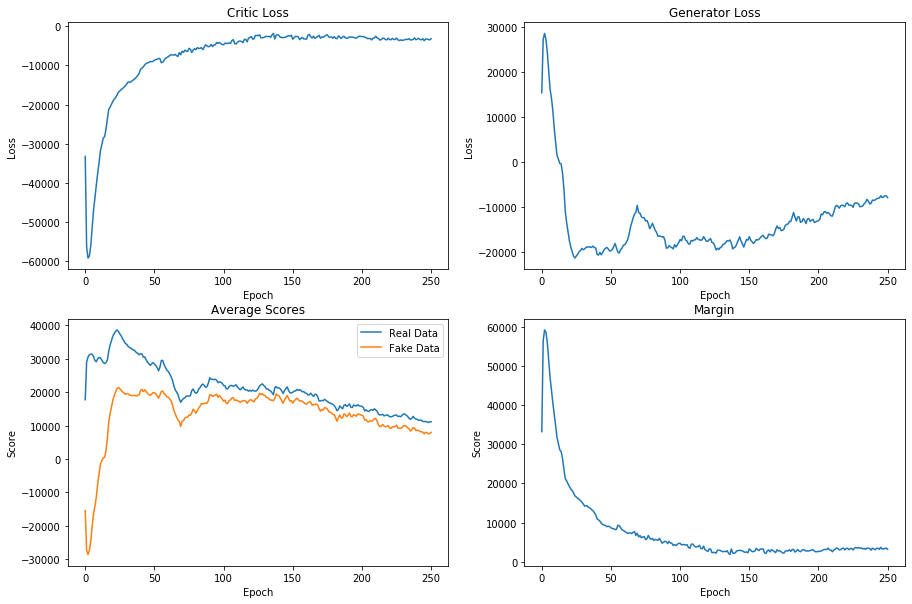

In [7]:
# Creates four polar axes, and accesses them through the returned array
#df = pd.read_csv('Logs/wgangp-2019-12-24_121154.csv', header=None) # LATEST WGAN-TP Model
df = pd.read_csv('Logs/wgan-2020-01-03_081141.csv', header=None) # LATEST WGAN model

## Logs/wgangp-2019-11-28_114731.csv - good 
## Logs/wgangp-2019-11-30_105956 + converged too fast

fig, axes = plt.subplots(2, 2, figsize=(15,10))

axes[0, 0].plot(df[1])
axes[0, 0].set_title('Critic Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 1].plot(df[2])
axes[0, 1].set_title('Generator Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_xlabel('Epoch')

axes[1, 0].plot(df[3])
#axes[1, 0].plot(df[4])
axes[1, 0].plot(df[5])
#axes[1, 0].legend(['Real Data: Train', 'Real Data: Val', 'Fake Data'])
axes[1, 0].legend(['Real Data', 'Fake Data'])
axes[1, 0].set_title('Average Scores')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xlabel('Epoch')

axes[1, 1].plot(df[3] - df[5])
axes[1, 1].set_title('Margin')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_xlabel('Epoch')


plt.show()
fig.savefig('Figs/WGAN_loss.png')

### Import real data

In [8]:
data = pd.read_pickle('Data/TU_onehot')
data = back_from_dummies(data) # original data
data = data.drop(['HomeAdrMunCode'], axis=1)
data_oh = encode_onehot(data) # one hot encoded data

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3606: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  result = self._constructor(new_data).__finalize__(self)


#### Load Functions and classes

In [9]:
def gen_noise(size:int, batch_size:int):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn([batch_size,size]), requires_grad=False)
    return n
def sample_gumbel(shape, eps=1e-20):
    unif = torch.rand(*shape).to(device)
    g = -torch.log(-torch.log(unif + eps))
    return g

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape)
    h = (g + logits)/temperature
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

INPUT_SIZE = 100
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [10]:
class Generator (nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 temperature: float,
                 cat: Counter):
        super(Generator, self).__init__()
        self.cat = cat
        self.cat_n = list(cat.values())
        self.output_size = sum(self.cat.values())
        self.temperature = torch.Tensor([temperature]).to(device)
        self.l1 = nn.Sequential( 
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(hidden_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l2 = nn.Sequential( 
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l3 = nn.Sequential( 
            nn.Linear(hidden_size * 2, hidden_size * 3),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l4 = nn.Sequential( 
            nn.Linear(hidden_size * 3, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential( 
            nn.Linear(hidden_size * 2, self.output_size))
        
    def forward(self,x):
        x=self.l1(x)
        x=self.l2(x)
        x=self.l3(x)
        x=self.l4(x)
        x=self.out(x)
        ### Softmax per class
        x = (x.split(self.cat_n, dim=1))
        out = torch.cat([sample_gumbel_softmax(v, temperature = self.temperature) for v in x], dim=1)
        return out

#G = torch.load('Logs/wgangp-2019-11-30_130226') # Latest WGAN-GP Generator
G = torch.load('Logs/wgan-2020-01-03_081141') # Latest WGAN Generator

In [11]:
G = G.to(device)
z = gen_noise(INPUT_SIZE, 100000).to(device)
output = G.forward(z)
output = output.cpu().detach().numpy()
output = output.astype(int) # to make sure that it is 0s and 1s (due to Gumbel Softmax it is not always teh case)

In [12]:
# Synthesised data to Pandas DataFrame 
fake_oh = pd.DataFrame(output, columns=data_oh.columns) #one-hot representation
fake = back_from_dummies(fake_oh) # convert to the original representation

In [13]:
#both real and fake DataFrames should be categorical
data = data.astype('category')
fake = fake.astype('category')

#### Joint Distributions

MAE:9.267993906463707e-05, MSE:2.1906071762101603e-06, RMSE:0.001480069990307945, SRSME:0.15786179790109697
corr = 0.718116
MAE = 0.000863
RMSE = 0.004518
SRMSE = 5.516135
r2 = 0.515507


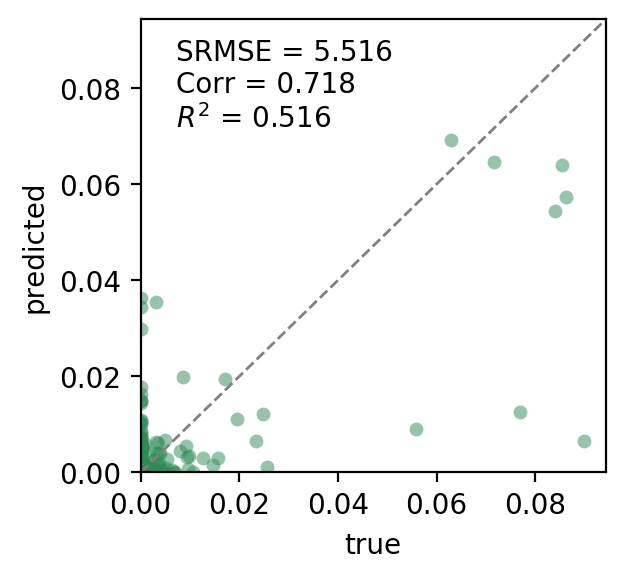

count_real  count_sampled  \
RespPrimOcc ResphasDrivlic RespAgeCorrect                                  
107         -18            (0.00198, 0.00702]    0.089822        0.00652   
                           (0.00702, 0.00904]    0.025600        0.00114   
            1              (0.00198, 0.00702]    0.000078        0.03447   
                           (0.00702, 0.00904]    0.000006        0.00768   
            2              (0.00702, 0.00904]    0.000484        0.00258   
...                                                   ...            ...   
140         3              (0.00198, 0.00702]    0.000000        0.00001   
284         1              (0.0261, 0.0516]      0.000000        0.00001   
175         2              (0.00198, 0.00702]    0.000000        0.00001   
            -18            (0.0228, 0.0261]      0.000000        0.00001   
291         1              (0.0228, 0.0261]      0.000000        0.00001   

                                                   diff  
RespPrimOcc ResphasDrivlic RespAgeCorrect                
107         -18            (0.00198, 0.00702]  0.083302  
                           (0.00702, 0.00904]  0.024460  
            1              (0.00198, 0.00702] -0.034392  
                           (0.00702, 0.00904] -0.007674  
            2              (0.00702, 0.00904] -0.002096  
...                                                 ...  
140         3              (0.00198, 0.00702] -0.000010  
284         1              (0.0261, 0.0516]   -0.000010  
175         2              (0.00198, 0.00702] -0.000010  
            -18            (0.0228, 0.0261]   -0.000010  
291         1              (0.0228, 0.0261]   -0.000010  

[1221 rows x 3 columns]

In [14]:
### This combination amounts to 1k different combinations
evaluate(data, fake,  ['RespPrimOcc', 'ResphasDrivlic', 'RespAgeCorrect'], data.columns, data, data)


MAE:9.445068148483111e-05, MSE:2.908708665724673e-07, RMSE:0.0005393244538980847, SRSME:0.04957092979563934
corr = 0.809209
MAE = 0.000211
RMSE = 0.000807
SRMSE = 3.045689
r2 = 0.499977


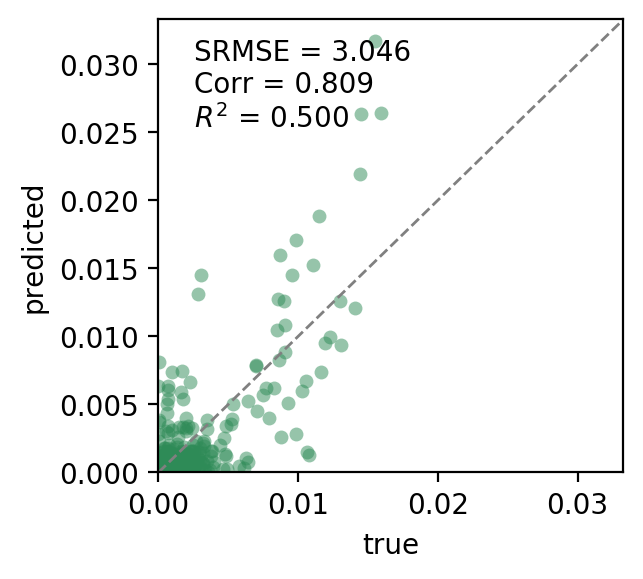

count_real  \
HomeAdrNUTS NuclFamType RespSex ResphasDrivlic Handicap HousehAccomodation               
42          21          2       -18            2        1                     0.006254   
                                                        3                     0.000574   
                                                        4                     0.000927   
                                                        2                     0.000466   
                                                        6                     0.000084   
...                                                                                ...   
14          11          1       3              2        1                     0.000000   
                                                        3                     0.000000   
                                               1        2                     0.000000   
                                -7             2        3                     0.000000   
                                -5             2        1                     0.000000   

                                                                            count_sampled  \
HomeAdrNUTS NuclFamType RespSex ResphasDrivlic Handicap HousehAccomodation                  
42          21          2       -18            2        1                         0.00106   
                                                        3                         0.00042   
                                                        4                         0.00024   
                                                        2                         0.00012   
                                                        6                         0.00000   
...                                                                                   ...   
14          11          1       3              2        1                         0.00001   
                                                        3                         0.00001   
                                               1        2                         0.00001   
                                -7             2        3                         0.00001   
                                -5             2        1                         0.00001   

                                                                                diff  
HomeAdrNUTS NuclFamType RespSex ResphasDrivlic Handicap HousehAccomodation            
42          21          2       -18            2        1                   0.005194  
                                                        3                   0.000154  
                                                        4                   0.000687  
                                                        2                   0.000346  
                                                        6                   0.000084  
...                                                                              ...  
14          11          1       3              2        1                  -0.000010  
                                                        3                  -0.000010  
                                               1        2                  -0.000010  
                                -7             2        3                  -0.000010  
                                -5             2        1                  -0.000010  

[3775 rows x 3 columns]

In [15]:
### This combination amounts to 8k different combinations
evaluate(data, fake,  ['HomeAdrNUTS', 'NuclFamType','RespSex', 'ResphasDrivlic', 'Handicap', 'HousehAccomodation'], data.columns, data, data)

MAE:1.9779453416652124e-06, MSE:7.252488175122285e-09, RMSE:8.516154164364502e-05, SRSME:0.06797235546080997
corr = 0.500656
MAE = 0.000115
RMSE = 0.000648
SRMSE = 7.124787
r2 = 0.250112


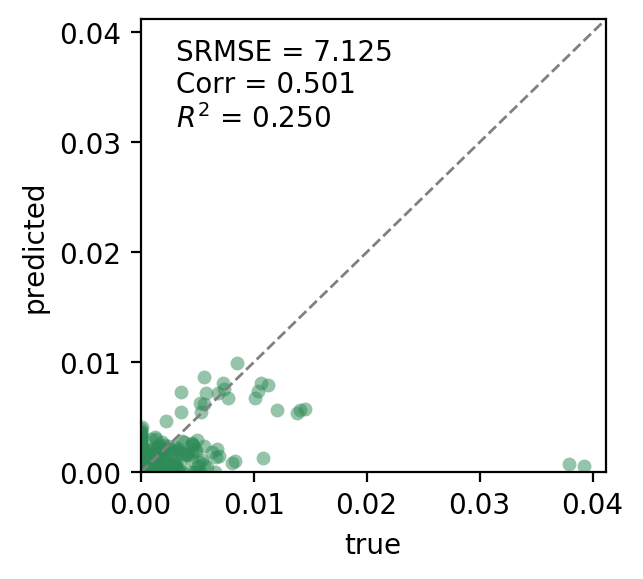

count_real  \
RespAgeCorrect     RespEdulevel RespSex ResphasDrivlic RespHasBicycle RespPrimOcc               
(0.00198, 0.00702] 1            2       -18            1              107            0.037898   
                                                                      116            0.000006   
                                                                      390            0.000012   
                                                                      103            0.000060   
                                                       2              107            0.002601   
...                                                                                       ...   
(0.0228, 0.0261]   10           2       -18            2              370            0.000000   
                                1       1              2              370            0.000000   
                                        2              2              370            0.000000   
                                        -18            1              107            0.000000   
                                        3              1              370            0.000000   

                                                                                   count_sampled  \
RespAgeCorrect     RespEdulevel RespSex ResphasDrivlic RespHasBicycle RespPrimOcc                  
(0.00198, 0.00702] 1            2       -18            1              107                0.00074   
                                                                      116                0.00000   
                                                                      390                0.00000   
                                                                      103                0.00003   
                                                       2              107                0.00042   
...                                                                                          ...   
(0.0228, 0.0261]   10           2       -18            2              370                0.00001   
                                1       1              2              370                0.00001   
                                        2              2              370                0.00001   
                                        -18            1              107                0.00001   
                                        3              1              370                0.00001   

                                                                                       diff  
RespAgeCorrect     RespEdulevel RespSex ResphasDrivlic RespHasBicycle RespPrimOcc            
(0.00198, 0.00702] 1            2       -18            1              107          0.037158  
                                                                      116          0.000006  
                                                                      390          0.000012  
                                                                      103          0.000030  
                                                       2              107          0.002181  
...                                                                                     ...  
(0.0228, 0.0261]   10           2       -18            2              370         -0.000010  
                                1       1              2              370         -0.000010  
                                        2              2              370         -0.000010  
                                        -18            1              107         -0.000010  
                                        3              1              370         -0.000010  

[10987 rows x 3 columns]

In [16]:
### This combination amounts to 128k different combinations
evaluate(data, fake,  ['RespAgeCorrect', 'RespEdulevel','RespSex', 'ResphasDrivlic', 'RespHasBicycle', 'RespPrimOcc'], data.columns, data, data)

MAE:2.37826326314148e-06, MSE:5.823570498626119e-09, RMSE:7.631232206286295e-05, SRSME:0.06460404858458452
corr = 0.196109
MAE = 0.000085
RMSE = 0.000455
SRMSE = 9.167859
r2 = 0.031085


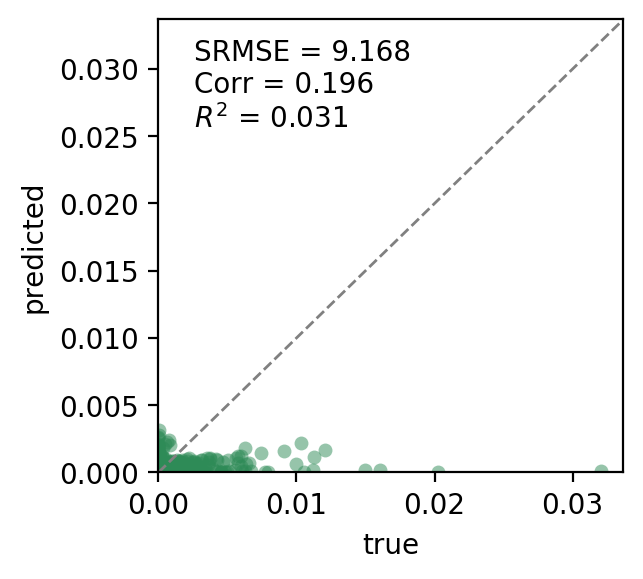

count_real  \
PosInFamily RespPrimOcc HousehNumAdults      RespEdulevel HousehNumPers1084                  
20          107         (0.001, 0.00107]     1            (0.00179, 0.00752]      0.004627   
                                                          (0.00143, 0.00179]      0.003019   
                                             9            (0.00179, 0.00752]      0.000012   
                                                          (0.00143, 0.00179]      0.000012   
                                             5            (0.00179, 0.00752]      0.000006   
...                                                                                    ...   
12          199         (0.000708, 0.000713] 1            (0.00179, 0.00752]      0.000000   
            213         (0.001, 0.00107]     11           (0.000716, 0.000722]    0.000000   
            167         (0.000721, 0.000725] 13           (0.00143, 0.00179]      0.000000   
            311         (0.000708, 0.000713] 1            (-0.001, 0.000362]      0.000000   
            277         (0.000721, 0.000725] 2            (-0.001, 0.000362]      0.000000   

                                                                                count_sampled  \
PosInFamily RespPrimOcc HousehNumAdults      RespEdulevel HousehNumPers1084                     
20          107         (0.001, 0.00107]     1            (0.00179, 0.00752]          0.00013   
                                                          (0.00143, 0.00179]          0.00018   
                                             9            (0.00179, 0.00752]          0.00000   
                                                          (0.00143, 0.00179]          0.00001   
                                             5            (0.00179, 0.00752]          0.00002   
...                                                                                       ...   
12          199         (0.000708, 0.000713] 1            (0.00179, 0.00752]          0.00001   
            213         (0.001, 0.00107]     11           (0.000716, 0.000722]        0.00001   
            167         (0.000721, 0.000725] 13           (0.00143, 0.00179]          0.00001   
            311         (0.000708, 0.000713] 1            (-0.001, 0.000362]          0.00001   
            277         (0.000721, 0.000725] 2            (-0.001, 0.000362]          0.00001   

                                                                                    diff  
PosInFamily RespPrimOcc HousehNumAdults      RespEdulevel HousehNumPers1084               
20          107         (0.001, 0.00107]     1            (0.00179, 0.00752]    0.004497  
                                                          (0.00143, 0.00179]    0.002839  
                                             9            (0.00179, 0.00752]    0.000012  
                                                          (0.00143, 0.00179]    0.000002  
                                             5            (0.00179, 0.00752]   -0.000014  
...                                                                                  ...  
12          199         (0.000708, 0.000713] 1            (0.00179, 0.00752]   -0.000010  
            213         (0.001, 0.00107]     11           (0.000716, 0.000722] -0.000010  
            167         (0.000721, 0.000725] 13           (0.00143, 0.00179]   -0.000010  
            311         (0.000708, 0.000713] 1            (-0.001, 0.000362]   -0.000010  
            277         (0.000721, 0.000725] 2            (-0.001, 0.000362]   -0.000010  

[20138 rows x 3 columns]

In [17]:
### This combination amounts to 6m different combinations
evaluate(data, fake,  ['PosInFamily', 'RespPrimOcc', 'HousehNumAdults' ,'RespEdulevel', 'HousehNumPers1084'], data.columns, data, data)

MAE:1.7898388995882447e-13, MSE:8.071189608908499e-18, RMSE:2.840983915637063e-09, SRSME:0.009496030009314043
corr = -0.289481
MAE = 0.000011
RMSE = 0.000022
SRMSE = 4.037511
r2 = -0.214721


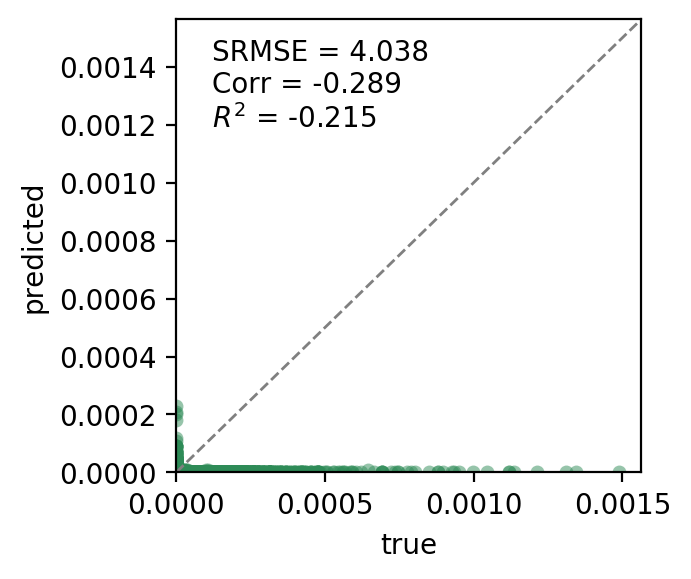

count_real  \
HomeAdrNUTS RespPrimOcc NuclFamType HousehAccOwnorRent HousehCarOwnership RespAgeCorrect     RespDrivlicYear            HousehNumcars        HousehNumPers        HousehNumAdults      HousehNumPers1084    HousehNumPersO6      HousehNumDrivLic                   
42          107         21          1                  1                  (0.00198, 0.00702] (-0.00050148, -0.00049775] (0.000363, 0.000502] (0.002, 0.0142]      (0.001, 0.00107]     (0.00179, 0.00752]   (0.002, 0.00752]     (0.000726, 0.001]       0.000138   
                                                                                                                                                                                                                                 (0.000363, 0.000708]    0.000006   
                                                                                                                                                                                       (0.00143, 0.00179]   (0.002, 0.00752]     (0.000726, 0.001]       0.000060   
                                                                                                                                                                                                                                 (0.000363, 0.000708]    0.000012   
                                                                                                                                                                                                            (0.00143, 0.002]     (0.000726, 0.001]       0.000006   
...                                                                                                                                                                                                                                                           ...   
14          282         21          1                  12                 (0.0228, 0.0261]   (0.71132, 0.72137]         (-0.001, 0.000356]   (0.000721, 0.000725] (0.000708, 0.000713] (0.00179, 0.00752]   (0.000711, 0.000719] (0.000708, 0.000713]    0.000000   
            112         21          3                  1                  (0.015, 0.0176]    (0.71058, 0.71132]         (0.000363, 0.000502] (0.00149, 0.002]     (0.000721, 0.000725] (0.000722, 0.000726] (-0.001, 0.000362]   (0.000713, 0.000717]    0.000000   
                        10          2                  0                  (0.00198, 0.00702] (-0.00053122, -0.00050148] (0.000363, 0.000502] (0.000725, 0.00107]  (0.000708, 0.000713] (0.000726, 0.00107]  (0.000711, 0.000719] (-0.001, 0.000357]      0.000000   
                                                       3                  (0.0261, 0.0516]   (0.71058, 0.71132]         (0.000363, 0.000502] (0.002, 0.0142]      (-0.001, 0.000361]   (0.00179, 0.00752]   (0.00102, 0.00108]   (-0.001, 0.000357]      0.000000   
            270         11          3                  0                  (0.00198, 0.00702] (0.71058, 0.71132]         (-0.001, 0.000356]   (0.002, 0.0142]      (0.000361, 0.000708] (0.000362, 0.00071]  (0.000362, 0.000711] (0.000357, 0.000363]    0.000000   

                                                                                                                                                                                                                                                       count_sampled  \
HomeAdrNUTS RespPrimOcc NuclFamType HousehAccOwnorRent HousehCarOwnership RespAgeCorrect     RespDrivlicYear            HousehNumcars        HousehNumPers        HousehNumAdults      HousehNumPers1084    HousehNumPersO6      HousehNumDrivLic                      
42          107         21          1                  1                  (0.00198, 0.00702] (-0.00050148, -0.00049775] (0.000363, 0.000502] (0.002, 0.0142]      (0.001, 0.00107]     (0.00179, 0.00752]   (0.002, 0.00752]     (0.000726, 0.001]           0.00000   
                                                             

In [18]:
### This combination amounts to 100b different combinations
evaluate(data, fake,  ['HomeAdrNUTS', 'RespPrimOcc','NuclFamType',
       'HousehAccOwnorRent', 'HousehCarOwnership', 'RespAgeCorrect',
       'RespDrivlicYear', 'HousehNumcars', 'HousehNumPers', 'HousehNumAdults',
       'HousehNumPers1084', 'HousehNumPersO6', 'HousehNumDrivLic'], data.columns, data, data)

### DF with real data

In [41]:
data[['HomeAdrNUTS', 'RespPrimOcc','NuclFamType',
       'HousehAccOwnorRent', 'HousehCarOwnership', 'RespAgeCorrect',
       'RespDrivlicYear', 'HousehNumcars', 'HousehNumPers', 'HousehNumAdults',
       'HousehNumPers1084', 'HousehNumPersO6', 'HousehNumDrivLic']].describe()

,HomeAdrNUTS,RespPrimOcc,NuclFamType,HousehAccOwnorRent,HousehCarOwnership,RespAgeCorrect,RespDrivlicYear,HousehNumcars,HousehNumPers,HousehNumAdults,HousehNumPers1084,HousehNumPersO6,HousehNumDrivLic
count,167264,167264,167264,167264,167264,167264,167264,167264,167264,167264,167264,167264,167264
unique,11,158,4,3,14,9,9,8,9,9,9,9,9
top,42,210,21,1,1,"(0.0124, 0.015]","(-0.00053122, -0.00050148]","(-0.001, 0.000356]","(0.000714, 0.000721]","(0.000717, 0.000721]","(0.000716, 0.000722]","(0.000719, 0.000723]","(0.000717, 0.000721]"
freq,25077,74938,69049,118257,93419,18589,18613,37171,18607,18597,18605,18614,18600


In [46]:
data.columns

Index(['HomeAdrNUTS', 'RespSex', 'RespPrimOcc', 'RespEdulevel',
       'RespHasBicycle', 'RespHasSeasonticket', 'ResphasDrivlic', 'Handicap',
       'HousehAccomodation', 'PosInFamily', 'NuclFamType',
       'HousehAccOwnorRent', 'HousehCarOwnership', 'RespAgeCorrect',
       'RespDrivlicYear', 'HousehNumcars', 'HousehNumPers', 'HousehNumAdults',
       'HousehNumPers1084', 'HousehNumPersO6', 'HousehNumDrivLic'],
      dtype='object')

In [65]:
data.shape

(167264, 21)